## Implementación del algoritmo de Kittler


In [1]:
import torch

In [2]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
U_1 = torch.tensor(
    np.array(Image.open('input/C4_02_1_1_DAPI_001.bmp').convert('L')))

output_path = "salida.png"
#example for writing image
Y = torch.zeros(U_1.shape)
print(Y)
Y_pil = Image.fromarray(Y.numpy().astype(np.uint8))
Y_pil.save(output_path)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [4]:
def get_image_tensor(path='input/cuadro1_005.bmp'):
  return torch.tensor(
      np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

In [5]:
def pre_process_tensor(image_tensor):
  return image_tensor.flatten().float()

In [6]:
data = pre_process_tensor(get_image_tensor())
print("Shape of tensor:", data.shape[0])
print(data)

Shape of tensor: 343980
tensor([219., 218., 219.,  ..., 221., 225., 224.])


In [7]:
def get_histogram(data, pdf=False):
  #hist_x = torch.histogram(data, bins=torch.unique(data, sorted=True),
  #                     min=data.min().item(), max=data.max().item())
  hist_x, bin_edges = torch.histogram(data, bins=torch.unique(data, sorted=True).numel())
  
  N = data.shape[0]

  y_axis = hist_x.numpy() if not pdf else hist_x / N
  x_axis = torch.unique(data, sorted=True)

  return x_axis, y_axis

### Calculo de Momentos Estadisticos

Implemente una funcion `calcular_momentos_estadisticos(T,p)` la cual reciba un umbral candidato *T* y una funcion de densidad *p*, y retorne todos los parametros de la función. Comente su implementacion con detalle en este informe


Este p es el mixto gasusiano (p, media 1, media 2, std, 1, std 2, P1, P2)

In [8]:
def calculate_p1(x, pdf, T):
    index = (x > T).nonzero()[0].item()
    #index -= 1
    index = 0 if index < 0 else index
    x1 = x[:index]
    pdf1 = pdf[:index]
    p1 = pdf[:index].sum().item()
    return x1, pdf1, p1

def calculate_p2(x, pdf, T):
    index = (x > T).nonzero()[0].item()
    #index -= 1
    x2 = x[index:]
    pdf2 = pdf[index:]
    p2 = pdf[index:].sum().item()

    return x2, pdf2, p2

In [9]:
def calculate_mu(x, pdf, p):
  mu = 0

  for i in range(len(x)):

    mu += (x[i].item() * pdf[i].item())
  
  return mu / p

In [10]:
def calculate_sigma(x, mu, pdf, p):
    variance = 0
    for i in range(len(x)):
        variance += pdf[i].item() * ((x[i].item() - mu) ** 2)
    return variance / p

In [11]:
def calculate_statistics(T, x, pdf):
  x1, pdf1, p1 = calculate_p1(x, pdf, T)
  x2, pdf2, p2 = calculate_p2(x, pdf, T)

  mean_1 = calculate_mu(x1, pdf1, p1)
  mean_2 = calculate_mu(x2, pdf2, p2)

  sigma_1 = calculate_sigma(x1, mean_1, pdf1, p1)
  sigma_2 = calculate_sigma(x2, mean_2, pdf2, p2)

  return mean_1, mean_2, sigma_1, sigma_2, p1, p2

### Calcular Costo

Implemente la función calcular_costo_J(T) la cual calcule el costo del umbral candidato T. Comente su implementacion con detalle en este informe.

In [14]:
def error_function(x, t, mu, sigma, P):
  i = 0 if x < t else 1

  error = ((x - mu[i]) / sigma[i])**2 + (2*np.log(mu[i])) - (2*np.log(P[i]))

  return error

In [15]:
# ver si se puede usar sin fors

def calculate_cost(hist_x, pdf_y, t, mu, sigma, P):
  cost = 0
  for i in range(len(hist_x)):
    cost += pdf_y[i] * error_function(hist_x[i], t, mu, sigma, P)

  return cost

### Calculo T Optimo

Basado en ambas funciones, implemente la función calcular_T_optimo_Kittler(Imagen) la cual retorne el T optimo para umbralizar la imagen recibida, además de la imagen umbralizada.

### Aplicación del Algoritmo de Kittler

Aplique el algoritmo de Kittler en la imagen cuadro1_005.bmp, pro-
vista

#### Graficación del histograma
Grafique el histograma normalizado de la imagen de entrada
provista

In [16]:
def get_image_tensor(path='input/cuadro1_005.bmp'):
  return torch.tensor(
      np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

In [17]:
def pre_process_tensor(image_tensor):
  return image_tensor.flatten().float()

In [18]:
data = pre_process_tensor(get_image_tensor())
print("Shape of tensor:", data.shape[0])
print(data)

Shape of tensor: 343980
tensor([219., 218., 219.,  ..., 221., 225., 224.])


In [19]:
def plot_histogram(data, title="Histogram", pdf=False):
  _, y_axis = get_histogram(data, pdf)
  y_label = "Frecuency" if not pdf else "Probabilities"

  plt.bar(data.unique().numpy(), y_axis, width=0.5, align='center')
  plt.xlabel('Values')
  plt.ylabel(y_label)
  plt.title(title)
  plt.grid(True)
  plt.show()


tensor([ 1.,  8., 10., 11., 12.])
[1. 0. 0. 1. 3.]


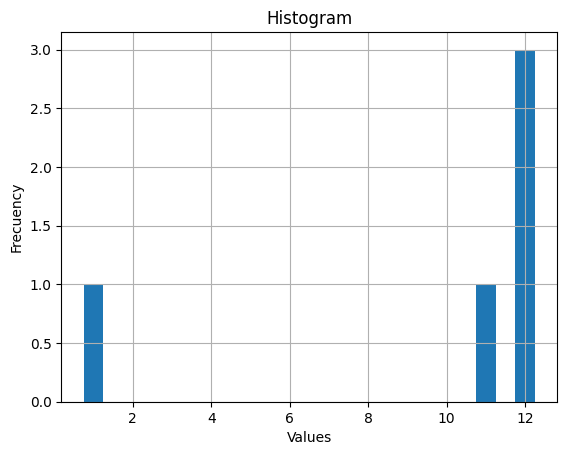

In [20]:
plot_histogram(x_test)

tensor([136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
        148., 149., 150., 151., 152., 153., 154., 155., 156., 157., 158., 159.,
        160., 161., 162., 163., 164., 166., 205., 206., 207., 208., 209., 210.,
        211., 212., 213., 214., 215., 216., 217., 218., 219., 220., 221., 222.,
        223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234.])
[6.0000e+00 3.0000e+01 4.0000e+01 1.5800e+02 4.3000e+02 3.7400e+02
 1.0060e+03 1.2730e+03 6.4800e+02 1.1640e+03 4.4100e+02 6.0400e+02
 2.6300e+02 5.6000e+01 5.2000e+01 1.2000e+01 1.0000e+00 2.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 1.3000e+01 1.8000e+01 2.4800e+02 1.6590e+03 2.5910e+03 1.4582e+04
 3.8850e+04 3.1155e+04 7.9839e+04 4.2115e+04 6.8542e+04 3.8889e

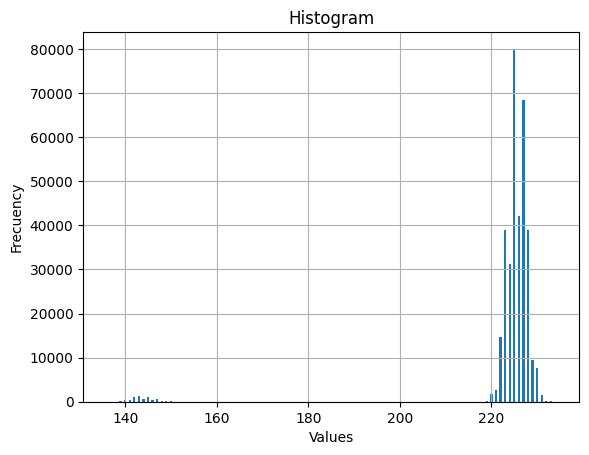

In [21]:
plot_histogram(data)

tensor([136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
        148., 149., 150., 151., 152., 153., 154., 155., 156., 157., 158., 159.,
        160., 161., 162., 163., 164., 166., 205., 206., 207., 208., 209., 210.,
        211., 212., 213., 214., 215., 216., 217., 218., 219., 220., 221., 222.,
        223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234.])
tensor([1.7443e-05, 8.7214e-05, 1.1629e-04, 4.5933e-04, 1.2501e-03, 1.0873e-03,
        2.9246e-03, 3.7008e-03, 1.8838e-03, 3.3839e-03, 1.2821e-03, 1.7559e-03,
        7.6458e-04, 1.6280e-04, 1.5117e-04, 3.4886e-05, 2.9071e-06, 5.8143e-06,
        2.9071e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7793e-05, 5.2329e-05, 7.2097e

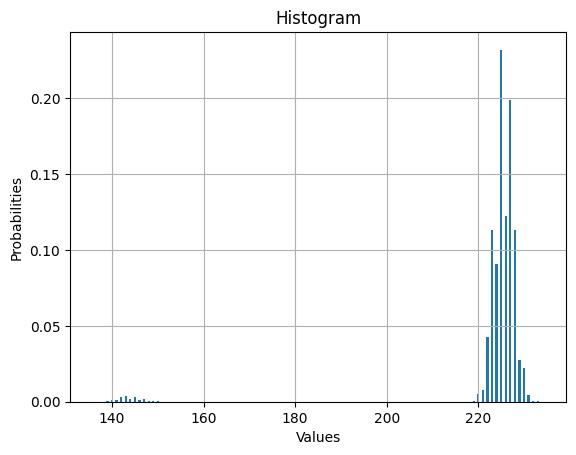

In [22]:
plot_histogram(data, pdf=True)

In [23]:
hist_x, pdf_y = get_histogram(data, pdf=True)

print("Proof of normalization:", pdf_y.sum().item())

tensor([136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
        148., 149., 150., 151., 152., 153., 154., 155., 156., 157., 158., 159.,
        160., 161., 162., 163., 164., 166., 205., 206., 207., 208., 209., 210.,
        211., 212., 213., 214., 215., 216., 217., 218., 219., 220., 221., 222.,
        223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234.])
tensor([1.7443e-05, 8.7214e-05, 1.1629e-04, 4.5933e-04, 1.2501e-03, 1.0873e-03,
        2.9246e-03, 3.7008e-03, 1.8838e-03, 3.3839e-03, 1.2821e-03, 1.7559e-03,
        7.6458e-04, 1.6280e-04, 1.5117e-04, 3.4886e-05, 2.9071e-06, 5.8143e-06,
        2.9071e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7793e-05, 5.2329e-05, 7.2097e

In [24]:
len(hist_x)

60

In [25]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt


def plot_kde(data_tensor, title='Kernel Density Estimation (KDE) Plot'):
    data_np = data_tensor.numpy()
    sns.kdeplot(data_np, fill=True, legend=False)
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.title(title)
    plt.grid(True)
    plt.show()

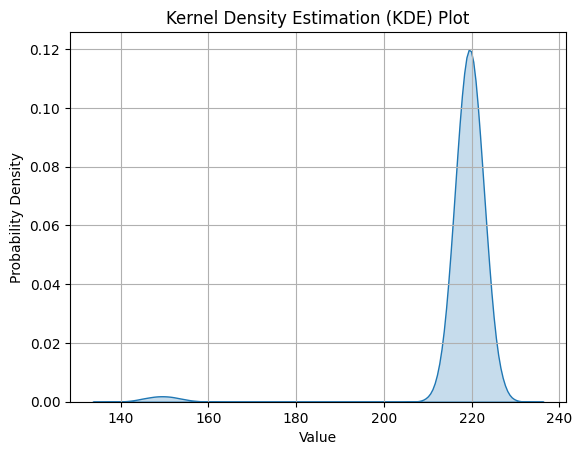

In [26]:
plot_kde(data)

### Distancia de Bhattacharyaa

Implemente la funcion´ calcular bhattacharyya distance(p,q), para comparar las funciones de densidad estimada con el ajuste del modelo mixto Gaussiano con Kittler p (x) y la aproximacion de la densidad
con el histograma de los datos q (x) para las dos pruebas realizadas
con la imagen y el audio.


In [27]:
#Estamos asumiendo que p y q son los valores de probabilidad, se puede depurar para que solo vengan las funciones y se calcula


def bhattacharyya_distance(p, q):
    device = p.device

    sqrt_product = torch.sqrt(p * q)
    sum_sqrt_product = torch.sum(sqrt_product)
    distance = -torch.log(sum_sqrt_product)

    return distance.item()

# Example usage:
p = torch.tensor([0.2, 0.3, 0.5])
q = torch.tensor([0.2, 0.3, 0.5])

distance = bhattacharyya_distance(p, q)
print("Bhattacharyya distance:", distance)

Bhattacharyya distance: -0.0


In [28]:
p = torch.tensor([0.2, 0.3, 0.5])
q = torch.tensor([0.2, 3.0])

p = p[:len(q)]
p

tensor([0.2000, 0.3000])

In [29]:
hist_x_left, pdf_y_left = get_histogram(data, pdf=True, threshold=180, left_t=True)
hist_x_right, pdf_y_right = get_histogram(data, pdf=True, threshold=180, left_t=False)

TypeError: get_histogram() got an unexpected keyword argument 'threshold'

In [ ]:
result = pdf_y_right.sum() + pdf_y_left.sum()
result

In [ ]:
len(hist_x_right)

In [ ]:
len(hist_x_left)